In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn.utils as utils

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)


In [43]:
df = pd.read_csv('ai_assistant_usage_student_life.csv')

print("Shape of DataFrame:", df.shape)

df.head()

Shape of DataFrame: (10000, 11)


,SessionID,StudentLevel,Discipline,SessionDate,SessionLengthMin,TotalPrompts,TaskType,AI_AssistanceLevel,FinalOutcome,UsedAgain,SatisfactionRating
0,SESSION00001,Undergraduate,Computer Science,2024-11-03,31.20,11,Studying,2,Assignment Completed,True,1.0
1,SESSION00002,Undergraduate,Psychology,2024-08-25,13.09,6,Studying,3,Assignment Completed,True,2.0
2,SESSION00003,Undergraduate,Business,2025-01-12,19.22,5,Coding,3,Assignment Completed,True,3.3
3,SESSION00004,Undergraduate,Computer Science,2025-05-06,3.70,1,Coding,3,Assignment Completed,True,3.5
4,SESSION00005,Undergraduate,Psychology,2025-03-18,28.12,9,Writing,3,Assignment Completed,True,2.9


In [44]:
df.isnull().sum()

SessionID             0
StudentLevel          0
Discipline            0
SessionDate           0
SessionLengthMin      0
TotalPrompts          0
TaskType              0
AI_AssistanceLevel    0
FinalOutcome          0
UsedAgain             0
SatisfactionRating    0
dtype: int64

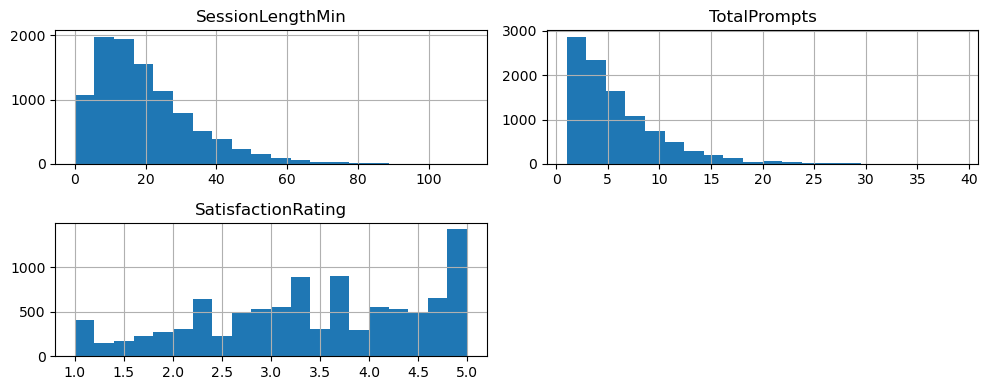

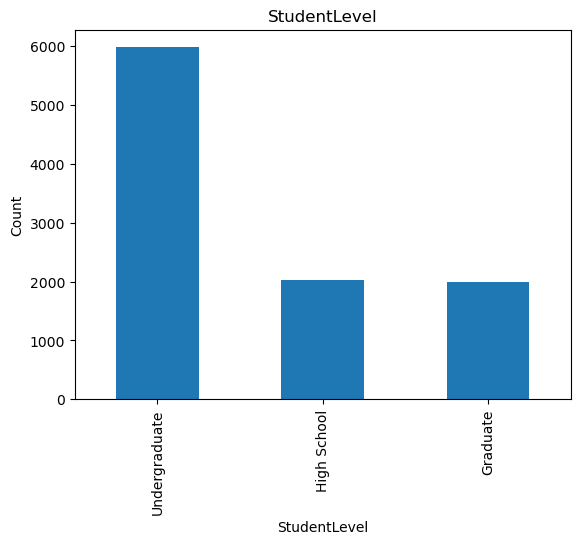

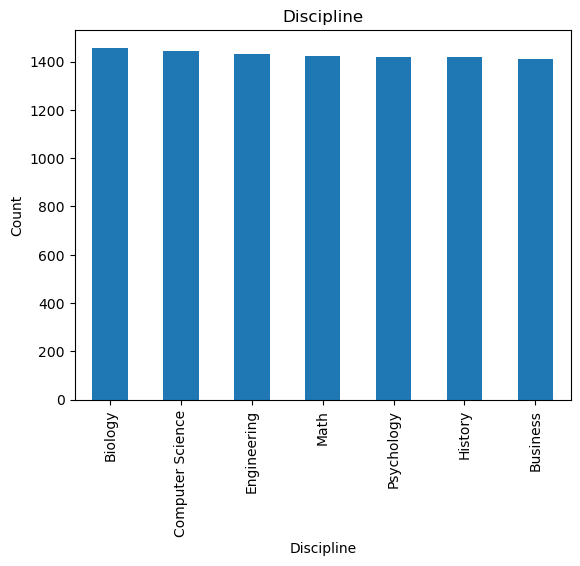

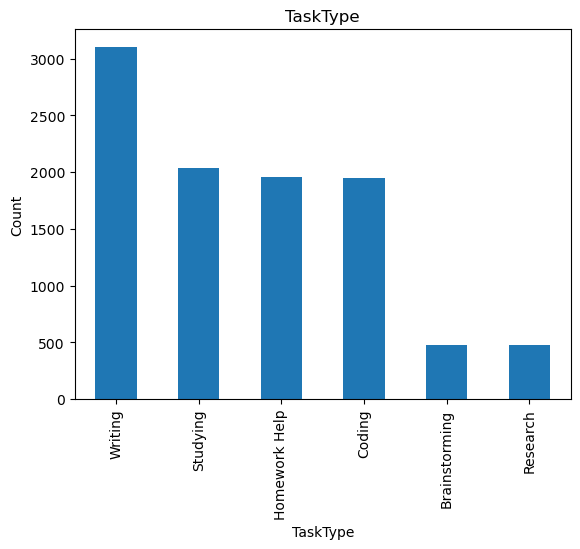

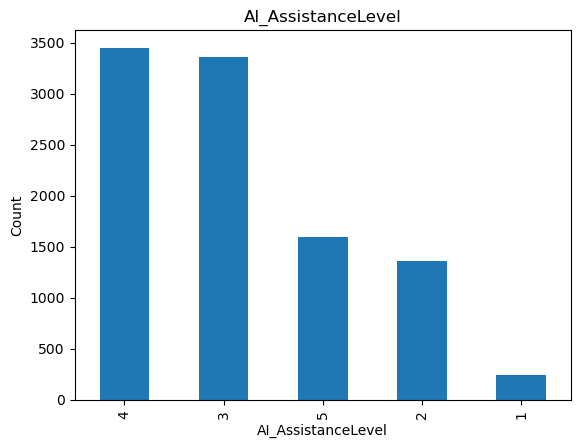

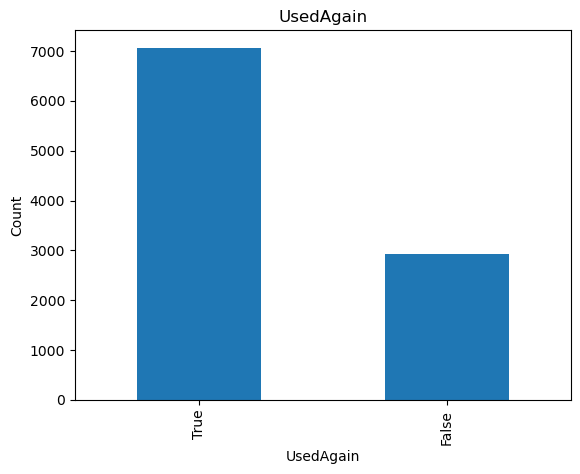

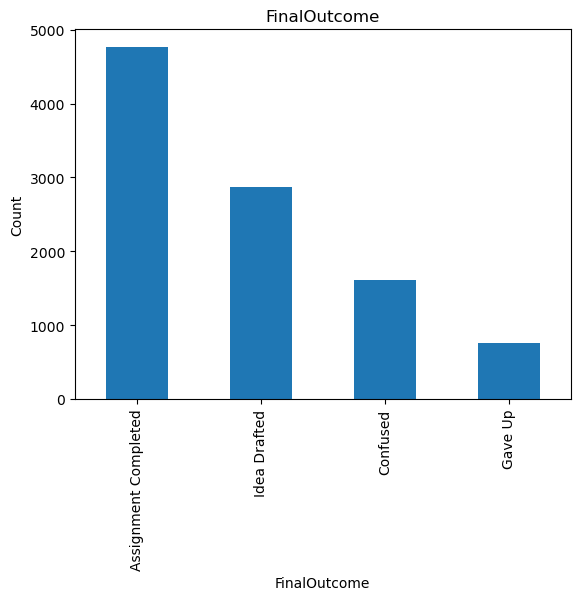

In [45]:
# Continuous: SessionLengthMin, TotalPrompts, SatisfactionRating
continuous_cols = ['SessionLengthMin', 'TotalPrompts', 'SatisfactionRating']

df[continuous_cols].hist(bins=20, figsize=(10, 4))
plt.tight_layout()
plt.show()

# Categorical: StudentLevel, Discipline, TaskType, AI_AssistanceLevel, UsedAgain, FinalOutcome
cat_cols_eda = ['StudentLevel', 'Discipline', 'TaskType', 'AI_AssistanceLevel', 'UsedAgain', 'FinalOutcome']

for col in cat_cols_eda:
    plt.figure()
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()



In [46]:
#Feature Engineering

In [47]:
productive_outcomes = ["Assignment Completed", "Idea Drafted"]

df['productive'] = (
    df['FinalOutcome'].isin(productive_outcomes) &
    (df['SatisfactionRating'] > 3)
).astype(int)

print(df['productive'].value_counts())
print(df[['FinalOutcome', 'productive']].head(20))

productive
0    5162
1    4838
Name: count, dtype: int64
            FinalOutcome  productive
0   Assignment Completed           0
1   Assignment Completed           0
2   Assignment Completed           1
3   Assignment Completed           1
4   Assignment Completed           0
5           Idea Drafted           1
6   Assignment Completed           0
7   Assignment Completed           1
8   Assignment Completed           1
9   Assignment Completed           0
10  Assignment Completed           0
11  Assignment Completed           1
12          Idea Drafted           1
13          Idea Drafted           1
14  Assignment Completed           1
15          Idea Drafted           0
16              Confused           0
17              Confused           0
18  Assignment Completed           1
19  Assignment Completed           1


In [48]:
df['SessionDate'] = pd.to_datetime(df['SessionDate'])

# Extract month
df['SessionMonth'] = df['SessionDate'].dt.month

# Define "school term"
# Fall (Sept–Dec) OR Winter (Jan–Apr) = True
# Summer (May–Aug) = False

df['InSchoolTerm'] = df['SessionMonth'].isin([1, 2, 3, 4, 9, 10, 11, 12]).astype(int)

# Sanity check
print(df[['SessionDate', 'SessionMonth', 'InSchoolTerm']].head(20))

   SessionDate  SessionMonth  InSchoolTerm
0   2024-11-03            11             1
1   2024-08-25             8             0
2   2025-01-12             1             1
3   2025-05-06             5             0
4   2025-03-18             3             1
5   2025-01-17             1             1
6   2024-09-07             9             1
7   2024-12-26            12             1
8   2025-06-18             6             0
9   2025-04-14             4             1
10  2025-02-24             2             1
11  2024-11-07            11             1
12  2024-07-05             7             0
13  2024-11-03            11             1
14  2025-05-21             5             0
15  2024-11-22            11             1
16  2025-04-27             4             1
17  2025-04-13             4             1
18  2024-12-08            12             1
19  2024-08-03             8             0


In [49]:
# Prompts per minute
df['PromptsPerMinute'] = df['TotalPrompts'] / df['SessionLengthMin'].replace(0, np.nan)
df['PromptsPerMinute'] = df['PromptsPerMinute'].fillna(0)

df['AI_LoadRatio'] = df['AI_AssistanceLevel'] / df['TotalPrompts'].replace(0, np.nan)
df['AI_LoadRatio'] = df['AI_LoadRatio'].fillna(0)   # If no prompts, ratio = 0

# Student Effort Score: How many prompts needed per unit AI capability
df['StudentEffort'] = df['TotalPrompts'] / df['AI_AssistanceLevel'].replace(0, np.nan)
df['StudentEffort'] = df['StudentEffort'].fillna(0)  # If AI_AssistanceLevel = 0, effort = 0

# Example STEM vs non-STEM grouping based on Discipline
stem_disciplines = {'Computer Science', 'Engineering', 'Mathematics', 'Physics', 'Biology', 'Chemistry'}
df['DisciplineGroup'] = np.where(df['Discipline'].isin(stem_disciplines), 'STEM', 'Non-STEM')

print(df.head(20))

       SessionID   StudentLevel        Discipline SessionDate  \
0   SESSION00001  Undergraduate  Computer Science  2024-11-03   
1   SESSION00002  Undergraduate        Psychology  2024-08-25   
2   SESSION00003  Undergraduate          Business  2025-01-12   
3   SESSION00004  Undergraduate  Computer Science  2025-05-06   
4   SESSION00005  Undergraduate        Psychology  2025-03-18   
5   SESSION00006       Graduate          Business  2025-01-17   
6   SESSION00007    High School           Biology  2024-09-07   
7   SESSION00008  Undergraduate           Biology  2024-12-26   
8   SESSION00009  Undergraduate          Business  2025-06-18   
9   SESSION00010  Undergraduate              Math  2025-04-14   
10  SESSION00011    High School              Math  2025-02-24   
11  SESSION00012  Undergraduate        Psychology  2024-11-07   
12  SESSION00013  Undergraduate           History  2024-07-05   
13  SESSION00014  Undergraduate          Business  2024-11-03   
14  SESSION00015    High 

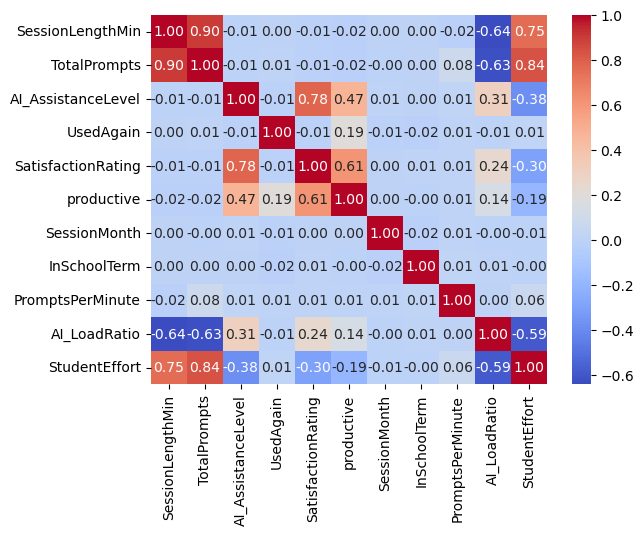

In [51]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Load the dataset
df = pd.read_csv('ai_assistant_usage_student_life.csv')

# 2. Target Label Creation
# Models student productivity as binary: 1 if "Assignment Completed", else 0
df['productive'] = (df['FinalOutcome'] == 'Assignment Completed').astype(int)

# 3. Boolean Conversion
# Convert boolean 'UsedAgain' column to numeric (1/0)
df['UsedAgain'] = df['UsedAgain'].astype(int)

# 4. Categorical Encoding (One-Hot Encoding)
# Select categorical columns to encode
categorical_cols = ['StudentLevel', 'Discipline', 'TaskType']
# Apply one-hot encoding
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 5. Feature Scaling
# Select continuous features to scale
continuous_features = ['SessionLengthMin', 'TotalPrompts', 'SatisfactionRating', 'AI_AssistanceLevel']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the continuous features
df[continuous_features] = scaler.fit_transform(df[continuous_features])

# 6. Prepare Data for Splitting
# Define Features (X) and Target (y)
# Drop columns that aren't features or are the target itself
# Note: Dropping 'SessionID', 'SessionDate', 'FinalOutcome' (source of target), and 'productive' (target)
X = df.drop(columns=['SessionID', 'SessionDate', 'FinalOutcome', 'productive'])
y = df['productive']

# 7. Data Splitting
# 80/20 stratified train-test split to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Output the shapes to verify
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("\nFirst 5 rows of processed training data:")
print(X_train.head())